# Perceived Dependence of Stocks and Correlation: Monthly Regression

For my thesis, i will look into the difference between the perceived dependence and the actual correlation of the return of stocks with the market return. In this notebook, we aim to integrate data from different sources and prepare it for analysis.

**Difference with main results: an extra excel is read in to read the risk-free retun and replace the monthly market premium factor.**

**Difference with main results: Only analyzes the period of Jan 2002-Dec 2012, instead of until Feb 2024. The dates Excel and Section 3 (only the variables start_date and end_date) is altered.**

In [ ]:
# TODO Datums overal aanpassen zodat March 2024 nergens meer included is en het nog steeds werkt. Mss Periode Variabiliseren?
# TODO Nakijken wat die NaN is in de stocks return data en of dat uitmaakt
#TODO Als ik tijd heb die statistics bereken opcleanen want nu verwarrend

## Imports

We will need the following imports:

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from pandas.tseries.offsets import MonthBegin, MonthEnd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

If you don't have any of these packages, u can install them using pip if necessary:

In [ ]:
pip install pandas openpyxl yfinance

## Data Collection

### Reading the Data from Excel

#### Indexes and Dates

Let's first read in the excel where I defined the correct time periods for every monthly data point. In this excel, i defined the month and years to be tested, and the periods that will be used for this month-year in the calculation of various variables. This will later be used to define variables: returns in these periods are used to calculate the frequency of comovement, beta and the return of stocks. Since returns are only available on weekdays, each start- and end date are adjusted in case they are on weekend.

The definitions of the variables for each MMYY from January 2002 to February 2023 are clarified as follows:

- **Monthly Stock Return**: This is calculated by determining the percentage difference between the stock's return on the last weekday before the start of the month (StartMonthMinus1_Weekday) and the stock's return on the last weekday of the month (EndMonth_Weekday). For example, the returns of Tuesday 31 December 2019 until Friday 31 January 2020 are used to calculate the return in January 2020.

- **Beta and Comovement**: For any given month, these metrics are calculated based on the returns from the index and the stock returns from the year preceding that month. The calculation period begins on the last weekday before the start of the previous year (StartPastYearMinus1_Weekday) and ends on the last weekday before the start of the month in question (EndPastYear_Weekday). In our example of January 2020, returns between Monday 31 December 2018 and Tuesday 31 December 2019 would be considered.

While beta is calculated using daily return differences, comovement is measured using weekly return differences. Note the **Minus 1 Day**: The day preceding the start of each period is also considered in the calculations to include the return percentage on the first day of the period.

In [ ]:
Dates_ExcelPath = "Dates.xlsx"
dates = pd.read_excel(Dates_ExcelPath)
dates.head(2)

,Month,Year,Index,StartMonth,StartMonth_Weekday,StartMonthMinus1,StartMonthMinus1_Weekday,EndMonth,EndMonth_Weekday,StartPastYear,StartPastYear_Weekday,StartPastYearMinus1,StartPastYearMinus1_Weekday,EndPastYear,EndPastYear_Weekday
0,1,2002,102,2002-01-01,2002-01-01,2001-12-31,2001-12-31,2002-01-31,2002-01-31,2001-01-01,2001-01-01,2000-12-31,2000-12-29,2001-12-31,2001-12-31
1,2,2002,102,2002-02-01,2002-02-01,2002-01-31,2002-01-31,2002-02-28,2002-02-28,2001-02-01,2001-02-01,2001-01-31,2001-01-31,2002-01-31,2002-01-31


In [ ]:
# Step 1: Convert 'Index' to string and prepend zeros if less than 4 characters.
dates['Index'] = dates['Index'].apply(lambda x: f'{x:04}')
dates.head(2)

,Month,Year,Index,StartMonth,StartMonth_Weekday,StartMonthMinus1,StartMonthMinus1_Weekday,EndMonth,EndMonth_Weekday,StartPastYear,StartPastYear_Weekday,StartPastYearMinus1,StartPastYearMinus1_Weekday,EndPastYear,EndPastYear_Weekday
0,1,2002,0102,2002-01-01,2002-01-01,2001-12-31,2001-12-31,2002-01-31,2002-01-31,2001-01-01,2001-01-01,2000-12-31,2000-12-29,2001-12-31,2001-12-31
1,2,2002,0102,2002-02-01,2002-02-01,2002-01-31,2002-01-31,2002-02-28,2002-02-28,2001-02-01,2001-02-01,2001-01-31,2001-01-31,2002-01-31,2002-01-31


#### Daily Stock Returns

For each month, we have used the dates to construct the following prompt in DataStream:

     DSGRID("LDJSTOXXMMYY";"X(RI)~E";"{start_date}"; "{end_date}";"{row["Freq"]}";"RowHeader=true;TimeSeriesList=true;ColHeader=true;Transpose=true;Curn=true;DispSeriesDescription=false;YearlyTSFormat=false;QuarterlyTSFormat=false;MonthlyTSFormat=False";"")'
     
This is used to save the daily returns of each month and the year prior to this month in an excel called 'Stocks_Return'. For the Index, the code DJSTOXX~01 is used. The ~E after the return index refers to prices that are all in euro.

We will first read in the Excel file where the daily returns of the stocks are saved. These are loaded in DataStream and are not modified. The formulas are generated with the other notebook.  The *Stocks_DailyReturn_Dataframes['MMYY']*  are used to save these dataframes.

In [ ]:
# Path to the Excel file
file_path = 'Stocks_DailyReturn.xlsx'

# Initialize an empty dictionary to store dataframes
Stocks_DailyReturn_Dataframes = {}

# Read the unique index values from the 'dates' dataframe
unique_indexes = dates['Index'].unique()

# Loop through each unique index value
for index_value in unique_indexes:
    # Construct the sheet name from the index value
    sheet_name = str(index_value)
    try:
        # Attempt to read the sheet into a dataframe
        df = pd.read_excel(file_path, sheet_name=sheet_name, index_col=0)
        # Store the dataframe in the dictionary with the sheet name as the key
        Stocks_DailyReturn_Dataframes[sheet_name] = df
    except Exception as e:
        # If there's an error reading the sheet, print the error message
        print(f"Error reading sheet {sheet_name}: {e}")

In [ ]:
# At this point, Stocks_DailyReturn_Dataframes will contain all the dataframes keyed by their respective sheet names.
Stocks_DailyReturn_Dataframes['0102'].head(2)

,CURRENCY,2000-12-29 00:00:00,2001-01-01 00:00:00,2001-01-02 00:00:00,2001-01-03 00:00:00,2001-01-04 00:00:00,2001-01-05 00:00:00,2001-01-08 00:00:00,2001-01-09 00:00:00,2001-01-10 00:00:00,...,2002-03-18 00:00:00,2002-03-19 00:00:00,2002-03-20 00:00:00,2002-03-21 00:00:00,2002-03-22 00:00:00,2002-03-25 00:00:00,2002-03-26 00:00:00,2002-03-27 00:00:00,2002-03-28 00:00:00,2002-03-29 00:00:00
Name,,,,,,,,,,,,,,,,,,,,,
3I GROUP - TOT RETURN IND,E,823.58,823.58,795.30,758.38,829.48,856.33,844.27,841.79,828.14,...,517.59,527.79,527.27,518.79,519.18,518.21,517.33,520.69,544.36,544.36
ABB LTD N - TOT RETURN IND,E,1957.55,1957.55,1955.18,1849.66,1925.13,1939.00,1965.14,2007.85,1982.15,...,685.70,677.32,663.43,630.43,616.89,621.83,579.15,622.14,642.96,642.96


#### Daily Index Returns

As explained above, an excel file was also made with the help of datastream to save the daily return index of the EUR600. These are saved in a dataframe called *Index_DailyReturn_Dataframe*.

In [ ]:
# The path to the Excel file
Index_DailyReturn_ExcelPath = 'Index_DailyReturn.xlsx'

# Read the specified sheet into a DataFrame
Index_DailyReturn_Dataframe = pd.read_excel(Index_DailyReturn_ExcelPath)
Index_DailyReturn_Dataframe.head(2)

,Date,Return Index
0,2000-12-29,100.0
1,2001-01-01,100.0


#### Daily Risk-Free Returns

In [ ]:
# Load the Excel file
file_path = 'RiskFree_DailyReturn.xlsx'
sheets = pd.read_excel(file_path, sheet_name=None)

# Extract sheet names
sheet_names = list(sheets.keys())
print(sheet_names)

# Load sheets individually
dfEONIA = pd.read_excel(file_path, sheet_name=sheet_names[0])
dfSTR = pd.read_excel(file_path, sheet_name=sheet_names[1])

# Convert date columns to datetime
dfEONIA['Date'] = pd.to_datetime(dfEONIA['Date'])
dfSTR['Date'] = pd.to_datetime(dfSTR['Date'])

['EONIA', 'Euro Short Term Rate']


In [ ]:
dfEONIA.head(2)

,Date,Return Index
0,2000-12-01,NaN
1,2000-12-04,NaN


In [ ]:
dfSTR.head(2)

,Date,Return Index
0,2019-11-01,99.9533
1,2019-11-04,99.9488


### Monthly Frequency of Comovement

To calculate the frequency of comovement of a particular MMYY, we compare the sign of the weekly return percentage on the stock and on the index for each week of the year prior to that month. Then we calculate in how many percent of the 52 week, the same sign is seen for both return percentages.

#### Weekly Stock Returns

##### Weekly Absolute Return Index of Stocks

First, we will make for each MMYY a dataframe with the absolute return indexes of all the stocks in the past 52 weeks before that month. We will look at the year before the month. We are starting with the first weekday of the previous year (column StartPastYear_Weekday). We will end with the last weekday of the previous year (column EndPastYear_Weekday). We will store them into the *Stocks_WeeklyReturn_Dataframes['MMYY]*.

In [ ]:
# Stocks_DailyReturn_Dataframes = {'IndexName': dataframe, ...}
# Initialize the dictionary to store the monthly dataframes
Stocks_WeeklyReturn_Dataframes = {}

# Define the start and end dates
start_date = datetime(2002, 1, 1)
end_date = datetime(2024, 3, 31)

# Generate the monthly periods
monthly_periods = pd.date_range(start_date, end_date, freq='M')

for period in monthly_periods:
    # Extract the year and month
    year = period.year
    month = period.month

    # Format the DataFrame name as MMYY
    df_name = f"{month:02d}{year}"

    # Filter the dates DataFrame for the current month and year
    # Assuming 'dates_df' is your DataFrame with 'Month', 'Year', 'Index',
    # 'StartPastYear_Weekday', and 'EndPastYear_Weekday' columns
    matching_rows = dates[(dates['Month'] == month) & (dates['Year'] == year)]

    # Initialize a list to collect data for the current month
    data_for_month = []

    for _, row in matching_rows.iterrows():
        index_name = row['Index']
        start_date = row['StartPastYear_Weekday']
        end_date = row['EndPastYear_Weekday']

        # Access the corresponding daily returns DataFrame
        daily_returns_df = Stocks_DailyReturn_Dataframes.get(index_name)

        if daily_returns_df is not None:

            # Find the columns for start and end dates
            columns = daily_returns_df.columns
            start_col = np.where(columns == pd.Timestamp(start_date))[0][0]
            end_col = np.where(columns == pd.Timestamp(end_date))[0][0]

            # Extract the data between these dates
            data = daily_returns_df.iloc[:, start_col:end_col+1]
            data_for_month.append(data)

    # Concatenate all dataframes for the month (if any) and store in the dictionary
    if data_for_month:
        Stocks_WeeklyReturn_Dataframes[df_name] = pd.concat(data_for_month, axis=1)

In [ ]:
# At this point, Stocks_WeeklyReturn_Dataframes will have all the MMYY dataframes as required.
Stocks_WeeklyReturn_Dataframes["012002"].head(2)

,2001-01-01,2001-01-02,2001-01-03,2001-01-04,2001-01-05,2001-01-08,2001-01-09,2001-01-10,2001-01-11,2001-01-12,...,2001-12-18,2001-12-19,2001-12-20,2001-12-21,2001-12-24,2001-12-25,2001-12-26,2001-12-27,2001-12-28,2001-12-31
Name,,,,,,,,,,,,,,,,,,,,,
3I GROUP - TOT RETURN IND,823.58,795.30,758.38,829.48,856.33,844.27,841.79,828.14,852.13,847.95,...,588.90,577.88,574.09,563.69,585.58,585.58,588.48,587.67,594.49,595.39
ABB LTD N - TOT RETURN IND,1957.55,1955.18,1849.66,1925.13,1939.00,1965.14,2007.85,1982.15,1883.67,1853.54,...,771.79,736.28,722.58,771.57,762.66,762.66,761.82,756.93,763.85,764.85


Secondly, we need to calculate the average per week. Note that the year not always starts on a monday and ends on a friday, so we do not always have five daily returns to calculate the weekly average. The 52 weekly averages are stored in *Stocks_WeeklyReturnAverages_Dataframes['MMYY']*.

In [ ]:
Stocks_WeeklyReturnAverages_Dataframes = {}

for key, df in Stocks_WeeklyReturn_Dataframes.items():
    Stocks_WeeklyReturnAverages_Dataframes[key] = df.resample('W', axis=1).mean()


In [ ]:
Stocks_WeeklyReturnAverages_Dataframes["012002"].head(2) #toevallig start 2001 op een maandag, maar werkt ook als eerste week niet begint op eerste weekdag

,2001-01-07,2001-01-14,2001-01-21,2001-01-28,2001-02-04,2001-02-11,2001-02-18,2001-02-25,2001-03-04,2001-03-11,...,2001-11-04,2001-11-11,2001-11-18,2001-11-25,2001-12-02,2001-12-09,2001-12-16,2001-12-23,2001-12-30,2002-01-06
Name,,,,,,,,,,,,,,,,,,,,,
3I GROUP - TOT RETURN IND,812.614,842.856,925.586,950.270,943.480,888.874,892.544,884.386,865.820,868.544,...,505.250,541.838,589.898,605.742,591.070,599.432,577.338,578.946,588.360,595.39
ABB LTD N - TOT RETURN IND,1925.304,1938.470,1862.414,1843.808,1825.868,1789.072,1608.592,1524.972,1558.942,1579.038,...,673.882,742.138,806.912,885.270,857.592,867.496,809.318,758.412,761.584,764.85


##### Weekly Relative Return Index of Stocks

For each MMYY, we now have a dataframe with the weekly average stock prices of each stock in the STOXX 600 in the year prior to MMYY. We will compare each week to the previous week in the dataframe. The first week will be compared to the last weekday before the previous year period starts (StartPastYearMinus1_Weekday). We will calculate percent of change in absolute return index. The week-on-week differences are stored in *Stocks_WeeklyReturnPercentages_Dataframes['MMYY']*.

In [ ]:
# Placeholder for the new dictionary to store percentage returns DataFrames
Stocks_WeeklyReturnPercentages_Dataframes = {}

for key, weekly_returns_df in Stocks_WeeklyReturnAverages_Dataframes.items():
    # Find the corresponding row in the dates DataFrame
    month, year = int(key[:2]), int(key[2:])
    date_info = dates[(dates['Month'] == month) & (dates['Year'] == year)]

    if not date_info.empty:
        # There should only be one row per month/year, but loop to handle unexpected data
        for _, row in date_info.iterrows():
            index_name = row['Index']
            start_date = row['StartPastYearMinus1_Weekday']

            # Access the daily return on the start date from the corresponding DataFrame
            daily_return_df = Stocks_DailyReturn_Dataframes.get(index_name)
            if daily_return_df is not None:
                start_return = daily_return_df.loc[:, pd.Timestamp(start_date)]

                # Calculate the percentage return for the first week compared to the start date
                first_week_return = weekly_returns_df.iloc[:, 0]

                first_week_percentage = (first_week_return - start_return) / start_return * 100

                # Calculate the week-on-week percentage returns for the rest of the weeks
                weekly_percentage_changes = weekly_returns_df.pct_change(axis=1) * 100

                # Replace the first column with the calculated first week percentage
                weekly_percentage_changes.iloc[:, 0] = first_week_percentage

                # Store the result in the new dictionary
                Stocks_WeeklyReturnPercentages_Dataframes[key] = weekly_percentage_changes

In [ ]:
# Now, Stocks_WeeklyReturnPercentages_Dataframes contains the week-on-week percentage returns for each month/year,
# including the first week's percentage calculated from the StartPastYearMinus1_Weekday.
Stocks_WeeklyReturnPercentages_Dataframes["012002"].head(2)

,2001-01-07,2001-01-14,2001-01-21,2001-01-28,2001-02-04,2001-02-11,2001-02-18,2001-02-25,2001-03-04,2001-03-11,...,2001-11-04,2001-11-11,2001-11-18,2001-11-25,2001-12-02,2001-12-09,2001-12-16,2001-12-23,2001-12-30,2002-01-06
Name,,,,,,,,,,,,,,,,,,,,,
3I GROUP - TOT RETURN IND,-1.331504,3.72157,9.815437,2.666851,-0.714534,-5.787722,0.412882,-0.914017,-2.099310,0.314615,...,-6.933265,7.241564,8.869810,2.685888,-2.422153,1.414722,-3.685823,0.278520,1.626058,1.194847
ABB LTD N - TOT RETURN IND,-1.647263,0.68384,-3.923507,-0.999026,-0.972986,-2.015261,-10.087911,-5.198335,2.227582,1.289079,...,5.157030,10.128776,8.728026,9.710848,-3.126504,1.154862,-6.706429,-6.289987,0.418242,0.428843


#### Weekly Index Returns

##### Weekly Absolute Return Index of EUR600

We follow the same steps as with the stocks. First, we will make for each MMYY a dataframe with the absolute return indexes of the index in the past 52 weeks prior to MMYY. We are starting with the first weekday of the previous year (column StartPastYear_Weekday). We will end with the last weekday of the previous year (column EndPastYear_Weekday). These are stored in *Index_WeeklyReturn_Dataframes['MMYY']*.

In [ ]:
# Initialize the dictionary to store the DataFrames
Index_WeeklyReturn_Dataframes = {}

# Create date range
start_date = datetime(2002, 1, 1)
end_date = datetime(2024, 3, 31)
date_range = pd.date_range(start_date, end_date, freq='MS')  # 'MS' is month start frequency

for single_date in date_range:
    month, year = single_date.month, single_date.year
    df_name = f"{month:02d}{year}"

    # Find the corresponding row in the dates DataFrame
    matching_rows = dates[(dates['Month'] == month) & (dates['Year'] == year)]

    for _, row in matching_rows.iterrows():
        index_name = row['Index']  # Though you mentioned Index, it seems like it's not used directly here.
        start_date = row['StartPastYear_Weekday']
        end_date = row['EndPastYear_Weekday']

        # Filter the Index_DailyReturn_Dataframe to get rows within the start and end date
        mask = (Index_DailyReturn_Dataframe['Date'] >= start_date) & (Index_DailyReturn_Dataframe['Date'] <= end_date)
        filtered_data = Index_DailyReturn_Dataframe.loc[mask, ['Date', 'Return Index ']]

        # Store this filtered data in the Index_WeeklyReturn_Dataframes dictionary
        Index_WeeklyReturn_Dataframes[df_name] = filtered_data

In [ ]:
# At this point, Index_WeeklyReturn_Dataframes will contain your required DataFrames.
Index_WeeklyReturn_Dataframes["012002"].head(2)

,Date,Return Index
1,2001-01-01,100.00
2,2001-01-02,99.09


Now we need to calculate the average per week. Note that the year not always starts on a monday and ends on a friday, so we do not always have five daily returns to calculate the weekly ones. We store these in *Index_WeeklyReturnAverages_Dataframes['MMYY'].*

In [ ]:
Index_WeeklyReturnAverages_Dataframes = {}

for key, df in Index_WeeklyReturn_Dataframes.items():
     # Ensure the 'Date' column is of datetime type and set it as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Now that 'Date' is the index, resample the DataFrame to get weekly averages.
    # Note: This assumes that you want to calculate the mean of the 'Return' column on a weekly basis.
    # If your DataFrame contains multiple columns you want to average, you might need to adjust this.
    weekly_avg_df = df.resample('W').mean()

    # Store the resulting DataFrame of weekly averages in the new dictionary
    Index_WeeklyReturnAverages_Dataframes[key] = weekly_avg_df


In [ ]:
Index_WeeklyReturnAverages_Dataframes["012002"].head(2)

,Return Index
Date,
2001-01-07,99.188
2001-01-14,98.274


##### Weekly Relative Return Index of EUR600

For each MMYY, we now have a dataframe with the weekly average return index of the STOXX 600 in the year prior to MMYY. We will compare each week to the previous week in the dataframe. The first week will be compared to the last weekday before the previous year period starts. We will calculate percent of change in total return index. These will be saved in *Index_WeeklyReturnPercentages_Dataframes['MMYY']*.

In [ ]:
Index_WeeklyReturnPercentages_Dataframes = {}

for key, weekly_returns_df in Index_WeeklyReturnAverages_Dataframes.items():
    # Convert key to month and year
    month, year = int(key[:2]), int(key[2:])
    # Find the corresponding information in the dates DataFrame
    date_info = dates[(dates['Month'] == month) & (dates['Year'] == year)]

    if not date_info.empty:
        for _, row in date_info.iterrows():
            index_name = row['Index']
            start_past_year_date = pd.to_datetime(row['StartPastYearMinus1_Weekday'])

            # Access the daily return on the start date from the corresponding DataFrame
            daily_return_df = Index_DailyReturn_Dataframe

            if daily_return_df is not None and start_past_year_date in daily_return_df['Date'].values:
                # Reset index if 'Date' is the index column
                daily_return_df_reset = daily_return_df.reset_index()
                start_return = daily_return_df_reset.loc[daily_return_df_reset['Date'] == start_past_year_date, 'Return Index '].values[0]

                # Reset index for weekly_returns_df to manipulate 'Date' as a column
                weekly_returns_df_reset = weekly_returns_df.reset_index()
                first_week_return = weekly_returns_df_reset.iloc[0]['Return Index ']
                # Calculate the percentage return for the first week compared to the start date
                first_week_percentage = ((first_week_return - start_return) / start_return) * 100

                # Calculate the week-on-week percentage returns for the rest of the weeks
                weekly_returns_df_reset['Weekly_Percentage_Change'] = weekly_returns_df_reset['Return Index '].pct_change() * 100
                # Replace the first percentage change with the calculated first week percentage
                weekly_returns_df_reset.loc[0, 'Weekly_Percentage_Change'] = first_week_percentage

                # Store the result in the new dictionary without resetting index
                Index_WeeklyReturnPercentages_Dataframes[key] = weekly_returns_df_reset.set_index('Date')[['Weekly_Percentage_Change']]



In [ ]:
Index_WeeklyReturnPercentages_Dataframes["012002"].head(2)

,Weekly_Percentage_Change
Date,
2001-01-07,-0.812000
2001-01-14,-0.921482


#### Comparing Weekly Returns

For each stock of EUR600 in MMYY, we now will make a dataframe *Stocks_Monthly_Dataframes['MMYY']*. The column *Comove* indicates how many of the weekly returns in Stocks_WeeklyReturnPercentages_Dataframes[MMYY] of that particular stock have the same sign as the weekly returns in Index_WeeklyReturnPercentages_Dataframes[MMYY].

Let's first make a function to calculate comove based on two series of weekly return percentages:

In [ ]:
# Example function to calculate the Comove value for a stock based on its weekly returns and the index's weekly returns
def calculate_comove(stock_weekly_returns, index_weekly_returns):

    # Calculate the signs (True if positive, False if negative) of the stock's weekly returns
    stock_signs = np.array(stock_weekly_returns > 0)

    # Calculate the signs of the index's weekly returns
    index_signs = np.array(index_weekly_returns > 0)

    # Determine the percentage of weeks where the stock's return sign matches the index's return sign
    matching_signs = np.equal(stock_signs, index_signs)
    matching_signs_percentage = np.mean(matching_signs) * 100
    return matching_signs_percentage

Let's apply the funciton on the data we have so far:

In [ ]:
# Create an empty dictionary to store the dataframes with monthly data of individual stocks
Stocks_Monthly_Dataframes = {}

# Define the start and end dates
start_date = datetime(2002, 1, 1)
end_date = datetime(2024, 3, 31)
# Generate the monthly periods
monthly_periods = pd.date_range(start_date, end_date, freq='M')

for period in monthly_periods:

   # Find dataframe names we need, based on the year
    df_name = str(period.month).zfill(2) + str(period.year)

    # Check if we have the data for the MMYY in question
    if df_name in Stocks_WeeklyReturnPercentages_Dataframes and df_name in Index_WeeklyReturnPercentages_Dataframes:

        # 1) Get the stock and index dataframes
        stocks_df = Stocks_WeeklyReturnPercentages_Dataframes[df_name]
        index_df = Index_WeeklyReturnPercentages_Dataframes[df_name]

        # 2) Calculate the 'Comove' values
        comove_values = stocks_df.apply(lambda row: calculate_comove(row, index_df.iloc[0]), axis=1) #for each row of the stocks_df (axis=1), apply the function
        # calculate_comove with as first parameter the row itself and as second parameter the first row of the index_df

        # 3) Create a DataFrame for the Comove values with the stock names as the index
        comove_df = pd.DataFrame({
            'Comove': comove_values
        }, index=stocks_df.index)

        # 4) Add to the dictionary
        Stocks_Monthly_Dataframes[df_name] = comove_df


In [ ]:
# This code would result in the Yearly_Dataframes dictionary being populated with a dataframe for each year from 2005 to 2024.
Stocks_Monthly_Dataframes["012002"].head(2)

,Comove
Name,
3I GROUP - TOT RETURN IND,47.169811
ABB LTD N - TOT RETURN IND,60.377358


### Monthly Beta

Later on, we will sort the individual stocks of each year into portfolios, based on the frequency of comovement and the beta. Therefore, we will need to add a column *Beta* to our *Stocks_Monthly_Dataframes['MMYY']* where we find the beta of each stock in that month. This is calculated using the daily returns in the year prior to MMYY.

**TODO:** Names of these intermediate dataframes can be adjusted to align with comovement more.

#### Daily Stock Returns

##### Daily Absolute Return Index of Stocks

First we find the data we need for each month for stock return index. We do this using the same period as explained in 2.2 about frequency of comovement. In this case, we will use daily return indexes and therefore not calculate weekly averages. Since we do not calculate weekly average, it is easier to already include the day prior to the start date now instead of later. The results are stored in *Stocks_DailyReturnPastYear_Dataframes['MMYYYY']*.

In [ ]:
# Stocks_DailyReturn_Dataframes = {'IndexName': dataframe, ...}
# Initialize the dictionary to store the monthly dataframes
Stocks_DailyReturnPastYear_Dataframes = {}

# Define the start and end dates
start_date = datetime(2002, 1, 1)
end_date = datetime(2024, 3, 31)

# Generate the monthly periods
monthly_periods = pd.date_range(start_date, end_date, freq='M')

for period in monthly_periods:
    # Extract the year and month
    year = period.year
    month = period.month

    # Format the DataFrame name as MMYY
    df_name = f"{month:02d}{year}"

    # Filter the dates DataFrame for the current month and year
    # Assuming 'dates_df' is your DataFrame with 'Month', 'Year', 'Index',
    # 'StartPastYear_Weekday', and 'EndPastYear_Weekday' columns
    matching_rows = dates[(dates['Month'] == month) & (dates['Year'] == year)]

    # Initialize a list to collect data for the current month
    data_for_month = []

    for _, row in matching_rows.iterrows():
        index_name = row['Index']
        start_date = row['StartPastYearMinus1_Weekday'] #HIER WEL ER AL BIJ DOEN MAKKELIJKER
        end_date = row['EndPastYear_Weekday']

        # Access the corresponding daily returns DataFrame
        daily_returns_df = Stocks_DailyReturn_Dataframes.get(index_name)

        if daily_returns_df is not None:

            # Find the columns for start and end dates
            columns = daily_returns_df.columns
            start_col = np.where(columns == pd.Timestamp(start_date))[0][0]
            end_col = np.where(columns == pd.Timestamp(end_date))[0][0]

            # Extract the data between these dates
            data = daily_returns_df.iloc[:, start_col:end_col+1]
            data_for_month.append(data)

    # Concatenate all dataframes for the month (if any) and store in the dictionary
    if data_for_month:
        Stocks_DailyReturnPastYear_Dataframes[df_name] = pd.concat(data_for_month, axis=1)

In [ ]:
Stocks_DailyReturnPastYear_Dataframes["022002"].head(2)

,2001-01-31,2001-02-01,2001-02-02,2001-02-05,2001-02-06,2001-02-07,2001-02-08,2001-02-09,2001-02-12,2001-02-13,...,2002-01-18,2002-01-21,2002-01-22,2002-01-23,2002-01-24,2002-01-25,2002-01-28,2002-01-29,2002-01-30,2002-01-31
Name,,,,,,,,,,,,,,,,,,,,,
3I GROUP - TOT RETURN IND,949.86,936.80,927.67,907.48,914.20,883.26,885.28,854.15,866.79,894.87,...,550.93,553.35,553.84,528.21,528.55,539.08,531.66,525.50,523.93,532.88
ABB LTD N - TOT RETURN IND,1837.97,1802.15,1817.31,1819.32,1829.76,1805.90,1753.66,1736.72,1755.70,1606.52,...,780.79,777.30,762.67,739.33,763.83,799.80,806.49,797.24,741.32,707.26


##### Daily Relative Return Index of Stocks

Then we find the daily return % for stocks, which will be stored in the dataframes *Stocks_DailyReturnPastYearPercentages_Dataframes['MMYYYY']*.

In [ ]:
# Placeholder for the new dictionary to store percentage returns DataFrames
Stocks_DailyReturnPastYearPercentages_Dataframes = {}

for key, weekly_returns_df in Stocks_DailyReturnPastYear_Dataframes.items():
                # Calculate the week-on-week percentage returns for all days -- firt day problem already civered
                weekly_percentage_changes = weekly_returns_df.pct_change(axis=1) * 100

                # Store the result in the new dictionary
                Stocks_DailyReturnPastYearPercentages_Dataframes[key] = weekly_percentage_changes.iloc[:,1:]

In [ ]:
Stocks_DailyReturnPastYearPercentages_Dataframes["022002"].head(2)

,2001-02-01,2001-02-02,2001-02-05,2001-02-06,2001-02-07,2001-02-08,2001-02-09,2001-02-12,2001-02-13,2001-02-14,...,2002-01-18,2002-01-21,2002-01-22,2002-01-23,2002-01-24,2002-01-25,2002-01-28,2002-01-29,2002-01-30,2002-01-31
Name,,,,,,,,,,,,,,,,,,,,,
3I GROUP - TOT RETURN IND,-1.374939,-0.974594,-2.176420,0.740512,-3.384380,0.228698,-3.516402,1.479834,3.239539,-2.171265,...,-3.071834,0.439257,0.088552,-4.627690,0.064368,1.992243,-1.376419,-1.158635,-0.298763,1.708243
ABB LTD N - TOT RETURN IND,-1.948889,0.841217,0.110603,0.573841,-1.303996,-2.892740,-0.965980,1.092865,-8.496896,-4.175485,...,-3.703658,-0.446983,-1.882156,-3.060301,3.313811,4.709163,0.836459,-1.146945,-7.014199,-4.594507


#### Daily Index Returns

##### Daily Absolute Return Index of EUR600

Secondly, we find the data we need for the index analogue to what we did with the stocks. We save the results in *Index_DailyReturnPastYear_Dataframes["MMYYYY"]*. Note that again, since we are using daily returns, we already include the day prior to this period.

In [ ]:
# Initialize the dictionary to store the DataFrames
Index_DailyReturnPastYear_Dataframes = {}

# Create date range
start_date = datetime(2002, 1, 1)
end_date = datetime(2024, 3, 31)
date_range = pd.date_range(start_date, end_date, freq='MS')  # 'MS' is month start frequency

for single_date in date_range:
    month, year = single_date.month, single_date.year
    df_name = f"{month:02d}{year}"

    # Find the corresponding row in the dates DataFrame
    matching_rows = dates[(dates['Month'] == month) & (dates['Year'] == year)]

    for _, row in matching_rows.iterrows():
        index_name = row['Index']  # Though you mentioned Index, it seems like it's not used directly here.
        start_date = row['StartPastYearMinus1_Weekday'] #HIER ER AL IN VEEL MAKKELIJKER
        end_date = row['EndPastYear_Weekday']

        # Filter the Index_DailyReturn_Dataframe to get rows within the start and end date
        mask = (Index_DailyReturn_Dataframe['Date'] >= start_date) & (Index_DailyReturn_Dataframe['Date'] <= end_date)
        filtered_data = Index_DailyReturn_Dataframe.loc[mask, ['Date', 'Return Index ']]

        # Store this filtered data in the Index_WeeklyReturn_Dataframes dictionary
        Index_DailyReturnPastYear_Dataframes[df_name] = filtered_data

In [ ]:
Index_DailyReturnPastYear_Dataframes["012002"].head(2)

,Date,Return Index
0,2000-12-29,100.0
1,2001-01-01,100.0


##### Daily Relative Return Index of EUR600

We now try to find the day-on-day percentual difference again. We store the results in *Index_DailyReturnPastYearPercentages_Dataframes["MMYYYY"]*.

In [ ]:
Index_DailyReturnPastYearPercentages_Dataframes = {}

for key, weekly_returns_df in Index_DailyReturnPastYear_Dataframes.items():

    # Calculate the week-on-week percentage returns for the rest of the weeks
    weekly_returns_df['Daily_Percentage_Change'] = weekly_returns_df['Return Index '].pct_change() * 100

    # Store the result in the new dictionary without resetting index
    Index_DailyReturnPastYearPercentages_Dataframes[key] = weekly_returns_df.set_index('Date')[['Daily_Percentage_Change']].iloc[1:, :]

In [ ]:
Index_DailyReturnPastYearPercentages_Dataframes["012002"].head(2)

,Daily_Percentage_Change
Date,
2001-01-01,0.00
2001-01-02,-0.91


#### Comparing Daily Returns

Using the daily relative returns of each stock in Stocks_DailyReturnPastYearPercentages_Dataframes['MMYYYY']  with the daily relative returns of the index in Index_DailyReturnPastYearPercentages_Dataframes["MMYYYY"], we calculate beta with its historical regression formula. This formula is set out in the following function:

In [ ]:
# Example function to calculate the Comove value for a stock based on its weekly returns and the index's weekly returns
def calculate_beta(stock_daily_returns, market_daily_returns):

    # Calculate covariance between stock and market
    covariance = stock_daily_returns.cov(market_daily_returns)

    # Calculate variance of the market
    variance = market_daily_returns.var()

    # Calculate beta
    beta = covariance / variance

    return beta

When applying the function, results are calculated and stored in the column *Beta* of the *Stocks_Monthly_Dataframes['MMYY']*.

In [ ]:
# Loop through the years

# Define the start and end dates
start_date = datetime(2002, 1, 1)
end_date = datetime(2024, 3, 31)

# Generate the monthly periods
monthly_periods = pd.date_range(start_date, end_date, freq='M')

for period in monthly_periods:

   # Find dataframe names we need, based on the year
    df_name = str(period.month).zfill(2) + str(period.year)

    # Check if we have the data for the year in question
    if df_name in Stocks_DailyReturnPastYearPercentages_Dataframes and df_name in Index_DailyReturnPastYearPercentages_Dataframes:

        # 1) Get the stock and index dataframes
        stocks_df = Stocks_DailyReturnPastYearPercentages_Dataframes[df_name]
        index_df = Index_DailyReturnPastYearPercentages_Dataframes[df_name]

        # 2) Calculate the beta values
        beta_values = stocks_df.apply(lambda row: calculate_beta(row, index_df.iloc[:,0]), axis=1) #for each row of the stocks_df (axis=1), apply the function
        # calculate_beta with as first parameter the row itself and as second parameter the first column of the index_df

        # 3) Add this columnn to the comove values we already had
        Stocks_Monthly_Dataframes[df_name]['Beta'] = beta_values

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b, ddof=ddof)[0, 1]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


In [ ]:
# This code would result in the Yearly_Dataframes dictionary being populated with a dataframe for each year from 2005 to 2024.
Stocks_Monthly_Dataframes["012002"].head(2)

,Comove,Beta
Name,,
3I GROUP - TOT RETURN IND,47.169811,1.405906
ABB LTD N - TOT RETURN IND,60.377358,1.675130


### Monthly Returns

After sorting the data, we will need the monthly return of the market (approximated by the index) and each stock. Let's already collect this data as well. Instead of the previous year returns we worked with for comove and beta, we now use the returns of the actual month.  

#### Monthly Stock Return

##### Absolute Monthly Return Index of Stocks

Let's first look at the daily returns from the last weekday before the start of the month until last day of the month. We store the results in   *Stocks_DailyReturnThisMonth_Dataframes["MMYYYY"]*. Since we use daily returns, we also already include the return index of the day prior to that month.

In [ ]:
# Stocks_DailyReturn_Dataframes = {'IndexName': dataframe, ...}
# Initialize the dictionary to store the monthly dataframes
Stocks_DailyReturnThisMonth_Dataframes = {}

# Define the start and end dates
start_date = datetime(2002, 1, 1)
end_date = datetime(2024, 3, 31)

# Generate the monthly periods
monthly_periods = pd.date_range(start_date, end_date, freq='M')

for period in monthly_periods:
    # Extract the year and month
    year = period.year
    month = period.month

    # Format the DataFrame name as MMYY
    df_name = f"{month:02d}{year}"

    # Filter the dates DataFrame for the current month and year
    # Assuming 'dates_df' is your DataFrame with 'Month', 'Year', 'Index',
    # 'StartPastYear_Weekday', and 'EndPastYear_Weekday' columns
    matching_rows = dates[(dates['Month'] == month) & (dates['Year'] == year)]

    # Initialize a list to collect data for the current month
    data_for_month = []

    for _, row in matching_rows.iterrows():
        index_name = row['Index']
        start_date = row['StartMonthMinus1_Weekday'] #HIER ER DUS WEL OOK AL BIJ
        end_date = row['EndMonth_Weekday']

        # Access the corresponding daily returns DataFrame
        daily_returns_df = Stocks_DailyReturn_Dataframes.get(index_name)

        if daily_returns_df is not None:

            # Find the columns for start and end dates
            columns = daily_returns_df.columns
            start_col = np.where(columns == pd.Timestamp(start_date))[0][0]
            end_col = np.where(columns == pd.Timestamp(end_date))[0][0]

            # Extract the data between these dates
            data = daily_returns_df.iloc[:, start_col:end_col+1]
            data_for_month.append(data)

    # Concatenate all dataframes for the month (if any) and store in the dictionary
    if data_for_month:
        Stocks_DailyReturnThisMonth_Dataframes[df_name] = pd.concat(data_for_month, axis=1)


In [ ]:
  Stocks_DailyReturnThisMonth_Dataframes["012002"].head(2)

,2001-12-31,2002-01-01,2002-01-02,2002-01-03,2002-01-04,2002-01-07,2002-01-08,2002-01-09,2002-01-10,2002-01-11,...,2002-01-18,2002-01-21,2002-01-22,2002-01-23,2002-01-24,2002-01-25,2002-01-28,2002-01-29,2002-01-30,2002-01-31
Name,,,,,,,,,,,,,,,,,,,,,
3I GROUP - TOT RETURN IND,595.39,595.39,578.56,590.31,605.97,604.36,602.20,591.70,571.40,574.98,...,550.93,553.35,553.84,528.21,528.55,539.08,531.66,525.50,523.93,532.88
ABB LTD N - TOT RETURN IND,764.85,764.85,776.60,836.05,875.67,856.11,845.33,863.46,857.59,862.19,...,780.79,777.30,762.67,739.33,763.83,799.80,806.49,797.24,741.32,707.26


##### Relative Monthly Return Index of Stocks

We take the return of the first and last day, and compare them in order to calculate the monthly stock return. Then we add it to our *Stocks_Monthly_Dataframes["MMYYYY"]* in the column *Return*.

In [ ]:
import pandas as pd
from datetime import datetime

# Assuming Stocks_DailyReturnThisMonth_Dataframes and Stock_Monthly_Dataframes are defined
# Example: Stocks_DailyReturnThisMonth_Dataframes = {'012002': df1, '022002': df2, ...}

# Define the start and end dates and generate monthly periods
start_date = datetime(2002, 1, 1)
end_date = datetime(2024, 3, 31)
monthly_periods = pd.date_range(start_date, end_date, freq='M')

# Iterate over each period
for period in monthly_periods:
    # Format MMYYYY for the dataframe names
    df_name = period.strftime("%m%Y")

    # Find the DataFrame for the current period in Stocks_DailyReturnThisMonth_Dataframes
    if df_name in Stocks_DailyReturnThisMonth_Dataframes:
        daily_return_df = Stocks_DailyReturnThisMonth_Dataframes[df_name]

        # Ensure there is more than one column to calculate return
        if len(daily_return_df.columns) > 1:
            # Get the start and end return
            start_return = daily_return_df.iloc[:, 0]  # First column
            end_return = daily_return_df.iloc[:, -1]  # Last column

            # Calculate the monthly return for each stock
            monthly_return = (end_return - start_return) / start_return * 100

            # Prepare the DataFrame for monthly returns if it does not exist
            if df_name not in Stocks_Monthly_Dataframes:
                Stocks_Monthly_Dataframes[df_name] = pd.DataFrame(index=daily_return_df.index)

            # Add the 'Monthly Return' column to the MMYYYY DataFrame in Stock_Monthly_Dataframes
            Stocks_Monthly_Dataframes[df_name]['Return'] = monthly_return
        else:
            print(f"DataFrame {df_name} does not have enough data to calculate monthly returns.")
    else:
        print(f"DataFrame {df_name} not found in Stocks_DailyReturnThisMonth_Dataframes.")


DataFrame 012013 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 022013 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 032013 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 042013 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 052013 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 062013 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 072013 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 082013 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 092013 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 102013 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 112013 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 122013 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 012014 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 022014 not found in Stocks_DailyReturnThisMonth_Dataframes.
DataFrame 032014 not

In [ ]:
Stocks_Monthly_Dataframes["012002"].head(2)

,Comove,Beta,Return,Beta rank,Comove rank
Name,,,,,
3I GROUP - TOT RETURN IND,47.169811,1.405906,-10.499001,5,1
ABB LTD N - TOT RETURN IND,60.377358,1.675130,-7.529581,5,5


####  Monthly Index Return

In the dataframe Index_DailyReturn_Dataframe, the absolute return index of every possible date is already given. For each MMY, we look up the date of last weekday before that month starts, and the last weekday of that month. These two dates are used to look up the absolute return index in this dataframe Index_DailyReturn_Dataframe. The two absolute return indexes are used to calculate the monthly relative difference. The results are stored in a dataframe *Index_MonthlyReturn_Dataframe* , with each MMYYY a row.

In [ ]:
# Initialize an empty dictionary to store the yearly market returns
monthly_market_returns = {}

# Define the start and end dates
start_date = datetime(2002, 1, 1)
end_date = datetime(2024, 3, 31)
# Generate the monthly periods
monthly_periods = pd.date_range(start_date, end_date, freq='M')

for period in monthly_periods:

     # Extract the year and month
    year = period.year
    month = period.month

    # Format the DataFrame name as MMYY
    df_name = f"{month:02d}{year}"

    # Filter the dates DataFrame for the current month and year
    # Assuming 'dates_df' is your DataFrame with 'Month', 'Year', 'Index',
    # 'StartPastYear_Weekday', and 'EndPastYear_Weekday' columns
    matching_rows = dates[(dates['Month'] == month) & (dates['Year'] == year)]

    # Initialize a list to collect data for the current month
    data_for_month = []

    for _, row in matching_rows.iterrows():
        index_name = row['Index']
        start_date = row['StartMonthMinus1_Weekday']
        end_date = row['EndMonth_Weekday']

        mask = (Index_DailyReturn_Dataframe['Date'] >= start_date) & (Index_DailyReturn_Dataframe['Date'] <= end_date)
        filtered_data = Index_DailyReturn_Dataframe.loc[mask, ['Date', 'Return Index ']]

        #now take % diff between first and last row of filtered data
        first_value = filtered_data['Return Index '].iloc[0]
        last_value = filtered_data['Return Index '].iloc[-1]
        percentage_change = (last_value - first_value) / first_value * 100

        # Store the result in the dictionary
        monthly_market_returns[df_name] = percentage_change


# Convert the dictionary to a DataFrame
Index_MonthlyReturn_Dataframe = pd.DataFrame(list(monthly_market_returns.items()), columns=['MMYYYY', 'Monthly Market Return'])

# Set the 'MMYYYY' column as the index
Index_MonthlyReturn_Dataframe.set_index('MMYYYY', inplace=True)

In [ ]:
# Display the resulting DataFrame
Index_MonthlyReturn_Dataframe.head(2)

,Monthly Market Return
MMYYYY,
012002,-2.030278
022002,-0.742693


### Monthly Control Factors

The factor data comes from various sources, and are saved in one excel called Factors_Monthly. For data definitions and sources of the factors, see the appendix. The sheet where all factors are on there together is saved as a dataframe called *Factors_Monthly_Dataframe*.

**TODO:** Nu zijn ze niet maal 100 gedaan, nakijken wat nu eigenlijk juist is. Ik denk dat die orginele 5 factors ook nog gedeeld moeten door 100. Ik heb dat nu gedaan dus we zullen kijken.

In [ ]:
# The path to the Excel file
Factors_Yearly_ExcelPath = 'Factors_Monthly.xlsx'
Factors_Monthly_SheetName = 'Factors_Monthly'

# Read the specified sheet into a DataFrame
Factors_Monthly_Dataframe = pd.read_excel(Factors_Yearly_ExcelPath, sheet_name=Factors_Monthly_SheetName)

In [ ]:
Factors_Monthly_Dataframe.head(2)

,Year,Month,MMYYYY,Mkt-RF,RF,SMB,HML,HML_Devil,RMW,CMA,UMD,UMD_Trend,BAB,QMJ,Carry,Seasonal
0,2000,1,12000,-0.0712,0.0041,0.0883,-0.0612,-0.075695,0.0265,-0.0428,0.069240,-0.034088,0.086910,0.016577,-0.011955,-0.003817
1,2000,2,22000,0.0587,0.0043,0.0083,-0.0950,-0.176450,0.0363,-0.0730,0.109318,0.039829,-0.044927,0.023143,0.058344,0.094229


We will replace the Mkt-RF column with the monthly market premiums of ourself, with the calculated the monthly market and risk-free return.

First we calculate the monthly risk-free rate:

In [ ]:
def calculate_monthly_return(df):
    df = df.set_index('Date')
    monthly_returns = []

    for date, group in df.groupby(pd.Grouper(freq='M')):
        last_day = group.index[-1]
        prev_month_end = (last_day - pd.offsets.MonthEnd(1)).strftime('%Y-%m-%d')
        if prev_month_end in df.index:
            prev_month_value = df.loc[prev_month_end].values[0]
        else:
            prev_month_value = group.iloc[0].values[0]  # Use first value in the month if previous month's end is not available

        month_return = (group.iloc[-1].values[0] - prev_month_value) / prev_month_value
        monthly_returns.append({'Date': last_day, 'Year': last_day.year, 'Month': last_day.month, 'Monthly Risk-Free Rate': month_return})

    return pd.DataFrame(monthly_returns)

In [ ]:
monthly_rf_EONIA = calculate_monthly_return(dfEONIA)
monthly_rf_STR = calculate_monthly_return(dfSTR)

In [ ]:
monthly_rf_EONIA.head(15)

,Date,Year,Month,Monthly Risk-Free Rate
0,2000-12-29,2000,12,NaN
1,2001-01-31,2001,1,NaN
2,2001-02-28,2001,2,-0.095935
3,2001-03-30,2001,3,-0.030061
4,2001-04-30,2001,4,0.082826
5,2001-05-31,2001,5,-0.014213
6,2001-06-29,2001,6,-0.039036
7,2001-07-31,2001,7,-0.048868
8,2001-08-31,2001,8,-0.083350
9,2001-09-28,2001,9,-0.119367


In [ ]:
monthly_rf_STR.head()

,Date,Year,Month,Monthly Risk-Free Rate
0,2019-11-29,2019,11,-0.000412
1,2019-12-31,2019,12,-0.000430
2,2020-01-31,2020,1,-0.000456
3,2020-02-28,2020,2,-0.000413
4,2020-03-31,2020,3,-0.000425


In [ ]:
# Merge monthly_rf dataframes
monthly_rf = pd.concat([monthly_rf_EONIA, monthly_rf_STR], ignore_index=True)

monthly_rf.head(5)

,Date,Year,Month,Monthly Risk-Free Rate
0,2000-12-29,2000,12,NaN
1,2001-01-31,2001,1,NaN
2,2001-02-28,2001,2,-0.095935
3,2001-03-30,2001,3,-0.030061
4,2001-04-30,2001,4,0.082826


Then we get the monthly market return from earlier calculations:

In [ ]:
# Reset the 'MMYYYY' column
Index_MonthlyReturn_Dataframe.reset_index(inplace=True)
Index_MonthlyReturn_Dataframe.head(15)

,MMYYYY,Monthly Market Return
0,012002,-2.030278
1,022002,-0.742693
2,032002,4.875694
3,042002,-3.751438
4,052002,-3.491153
5,062002,-8.733895
6,072002,-10.289127
7,082002,-0.015131
8,092002,-14.058717
9,102002,9.455890


In [ ]:
# Convert MMYYYY to Year and Month in Index_MonthlyReturn_Dataframe
Index_MonthlyReturn_Dataframe['Year'] = Index_MonthlyReturn_Dataframe['MMYYYY'].str[2:].astype(int)
Index_MonthlyReturn_Dataframe['Month'] = Index_MonthlyReturn_Dataframe['MMYYYY'].str[:2].astype(int)

Index_MonthlyReturn_Dataframe['Monthly Market Return'] = Index_MonthlyReturn_Dataframe['Monthly Market Return'] / 100 # This is already put in percentage form, not needed

Index_MonthlyReturn_Dataframe.head(5)

,MMYYYY,Monthly Market Return,Year,Month
0,012002,-0.020303,2002,1
1,022002,-0.007427,2002,2
2,032002,0.048757,2002,3
3,042002,-0.037514,2002,4
4,052002,-0.034912,2002,5


We merge them together:

In [ ]:
# Merge to get Monthly Market Return

# Filter out rows in Factors_Monthly_Dataframe before January 2002
Factors_Monthly_Dataframe = Factors_Monthly_Dataframe[(Factors_Monthly_Dataframe['Year'] > 2002) |
                                                      ((Factors_Monthly_Dataframe['Year'] == 2002) & (Factors_Monthly_Dataframe['Month'] >= 1))]


# Merge to get Monthly Market Return
merged_df = pd.merge(Factors_Monthly_Dataframe, Index_MonthlyReturn_Dataframe, on=['Year', 'Month'])
merged_df = pd.merge(merged_df, monthly_rf, on=['Year', 'Month'], how='left')

# Calculate Mkt-RF
merged_df['Mkt-RF'] = merged_df['Monthly Market Return'] - merged_df['Monthly Risk-Free Rate']


merged_df

,Year,Month,MMYYYY_x,Mkt-RF,RF,SMB,HML,HML_Devil,RMW,CMA,UMD,UMD_Trend,BAB,QMJ,Carry,Seasonal,MMYYYY_y,Monthly Market Return,Date,Monthly Risk-Free Rate
0,2002,1,12002,0.014325,0.0014,0.0323,0.0183,0.002349,0.0313,0.0258,0.057496,0.023426,0.000910,0.024064,0.018840,0.002665,012002,-0.020303,2002-01-31,-0.034628
1,2002,2,22002,0.004985,0.0013,-0.0002,0.0174,-0.020744,0.0285,0.0465,0.080470,0.002301,0.057646,0.047414,0.009606,-0.012346,022002,-0.007427,2002-02-28,-0.012412
2,2002,3,32002,0.004053,0.0013,-0.0048,0.0074,0.033359,0.0039,-0.0029,-0.028588,-0.029024,0.001396,-0.011611,0.008205,0.029164,032002,0.048757,2002-03-29,0.044704
3,2002,4,42002,0.014463,0.0015,0.0337,0.0476,0.010469,0.0139,0.0528,0.070559,0.016835,0.102856,0.010853,-0.006998,-0.003683,042002,-0.037514,2002-04-30,-0.051977
4,2002,5,52002,-0.002855,0.0014,0.0199,0.0470,0.016583,0.0016,0.0261,0.065026,0.015772,0.090014,0.006509,-0.008146,-0.003402,052002,-0.034912,2002-05-31,-0.032056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2012,8,82012,-0.028632,0.0001,0.0006,0.0319,0.009434,-0.0186,0.0148,-0.032338,-0.011670,0.002051,-0.029434,0.016292,0.005552,082012,0.021293,2012-08-31,0.049924
128,2012,9,92012,0.001405,0.0001,0.0165,0.0216,0.007253,-0.0152,0.0082,-0.016730,-0.000503,0.007281,-0.020820,0.005844,0.038333,092012,0.010240,2012-09-28,0.008835
129,2012,10,102012,0.005033,0.0001,-0.0056,0.0178,-0.005010,-0.0113,-0.0033,0.016291,0.003839,0.019103,-0.015798,0.026499,-0.000957,102012,0.007944,2012-10-31,0.002912
130,2012,11,112012,-0.007443,0.0001,-0.0244,-0.0058,-0.023004,0.0056,-0.0093,0.027905,0.007346,0.013152,0.011969,-0.006956,0.001718,112012,0.022015,2012-11-30,0.029458


In [ ]:
# Align indices and fill missing values with NaN
Factors_Monthly_Dataframe.set_index(['Year', 'Month'], inplace=True)
merged_df.set_index(['Year', 'Month'], inplace=True)

# Ensure that both dataframes have the same index
Factors_Monthly_Dataframe = Factors_Monthly_Dataframe.reindex(merged_df.index)

# Update the 'Mkt-RF' column in Factors_Monthly_Dataframe with values from merged_df
Factors_Monthly_Dataframe['Mkt-RF'] = merged_df['Mkt-RF']

# Reset the index
Factors_Monthly_Dataframe.reset_index(inplace=True)

Factors_Monthly_Dataframe

,Year,Month,MMYYYY,Mkt-RF,RF,SMB,HML,HML_Devil,RMW,CMA,UMD,UMD_Trend,BAB,QMJ,Carry,Seasonal
0,2002,1,12002,0.014325,0.0014,0.0323,0.0183,0.002349,0.0313,0.0258,0.057496,0.023426,0.000910,0.024064,0.018840,0.002665
1,2002,2,22002,0.004985,0.0013,-0.0002,0.0174,-0.020744,0.0285,0.0465,0.080470,0.002301,0.057646,0.047414,0.009606,-0.012346
2,2002,3,32002,0.004053,0.0013,-0.0048,0.0074,0.033359,0.0039,-0.0029,-0.028588,-0.029024,0.001396,-0.011611,0.008205,0.029164
3,2002,4,42002,0.014463,0.0015,0.0337,0.0476,0.010469,0.0139,0.0528,0.070559,0.016835,0.102856,0.010853,-0.006998,-0.003683
4,2002,5,52002,-0.002855,0.0014,0.0199,0.0470,0.016583,0.0016,0.0261,0.065026,0.015772,0.090014,0.006509,-0.008146,-0.003402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2012,8,82012,-0.028632,0.0001,0.0006,0.0319,0.009434,-0.0186,0.0148,-0.032338,-0.011670,0.002051,-0.029434,0.016292,0.005552
128,2012,9,92012,0.001405,0.0001,0.0165,0.0216,0.007253,-0.0152,0.0082,-0.016730,-0.000503,0.007281,-0.020820,0.005844,0.038333
129,2012,10,102012,0.005033,0.0001,-0.0056,0.0178,-0.005010,-0.0113,-0.0033,0.016291,0.003839,0.019103,-0.015798,0.026499,-0.000957
130,2012,11,112012,-0.007443,0.0001,-0.0244,-0.0058,-0.023004,0.0056,-0.0093,0.027905,0.007346,0.013152,0.011969,-0.006956,0.001718


## Data Preparation

We have now collected all the data of individual stocks. We need to sort the stocks in portfolios and write this to an excel before we can start our regression.

### Sorting the Stocks into Portfolio's

In [ ]:
# Define the start and end dates
start_date = datetime(2002, 1, 1)
end_date = datetime(2012, 12, 31)
# Generate the monthly periods
monthly_periods = pd.date_range(start_date, end_date, freq='M')

#### Defining Ranks

We now have a dataframe for each MMYY called Stocks_Monthly_Dataframes["MMYYYY"] with the column name, Comove and Beta. What i want to do now is the following:
- Step 1: Rank the stocks on beta. Divide the stocks into quintiles based on their beta value. Add a additional column called Beta rank where each stock gets a number between 1 and 5, based on the quintile they are in. This is 1 indicating the quintile with the lowest betas and 5 the highest.
- Step 2: For each quintile, filter the dataframe for only stocks within this quintile. Rank the filtered stocks on Comove. Divide the filtered stocks into quintiles based on their comove value. Add a additional column to the intial dataframe called Comove rank where each stock gets a number between 1 and 5, based on the quintile they are in. This is 1 indicating the quintile with the lowest comove and 5 the highest within each beta quintile.

This results in two extra columns in *Stocks_Monthly_Dataframes["MMYYYY"]*: *Comove rank* and *Beta rank*.

In [ ]:
for period in monthly_periods:
    # Extract the year and month
    year = period.year
    month = period.month

    # Format the DataFrame name as MMYY and find the correct dataframe
    df_name = f"{month:02d}{year}"
    df = Stocks_Monthly_Dataframes[df_name]

     # Step 1: Rank stocks on Beta and assign quintile ranks (1 to 5)
    df['Beta rank'] = pd.qcut(df['Beta'], 5, labels=False) + 1 #Note that when doing this, it will automatically ignore the remaining Nan values for beta

    # Step 2: For each Beta quintile, rank stocks on Comove within the quintile
    # Prepare a column for Comove ranks
    df['Comove rank'] = pd.NA
    for quintile in range(1, 6):
        # Filter for stocks in the current Beta quintile
        quintile_df = df[df['Beta rank'] == quintile]

        # Rank the filtered stocks on Comove and divide into quintiles
        comove_ranks = pd.qcut(quintile_df['Comove'], 5, labels=False) + 1

        # Assign the Comove ranks back to the original DataFrame
        df.loc[df['Beta rank'] == quintile, 'Comove rank'] = comove_ranks

        # Update the DataFrame in the dictionary
        Stocks_Monthly_Dataframes[df_name] = df


In [ ]:
# At this point, each DataFrame in Monthly_Dataframes has been updated with 'Beta rank' and 'Comove rank' columns.
Stocks_Monthly_Dataframes['012002'].head(2)

,Comove,Beta,Return,Beta rank,Comove rank
Name,,,,,
3I GROUP - TOT RETURN IND,47.169811,1.405906,-10.499001,5,1
ABB LTD N - TOT RETURN IND,60.377358,1.675130,-7.529581,5,5


#### Showing Beta and Comove across Portfolios

##### Beta and Comove across portfolios per month

We can use the Comove rank column to define our portfolio's for each month. By sorting in this matter, we have a strong exposure to Comove while holding Beta relatively constant across portfolio's. For every comove rank of this month, we calculate the average comove and return of all stocks in that portfolio. Apart from the mean, we also calculate the standard deviation of beta and comove of stocks in that portfolio.

In [ ]:
# Initialize lists to store the monthly differences for each statistic between the highest and the lowest comove
diff_mean_beta = []
diff_std_beta = []
diff_mean_comove = []
diff_std_comove = []

for period in monthly_periods:
    # Extract the year and month
    year = period.year
    month = period.month

    # Format the DataFrame name as MMYY and find the correct dataframe
    df_name = f"{month:02d}{year}"

    if df_name in Stocks_Monthly_Dataframes:
        df = Stocks_Monthly_Dataframes[df_name]

        # Ensure 'Comove rank' is not NA and is an integer for grouping
        df['Comove rank'] = df['Comove rank'].astype(pd.Int64Dtype()).dropna()

        # Group by 'Comove rank'
        grouped = df.groupby('Comove rank')

        # Calculate statistics for each group
        stats = grouped.agg({
            'Beta': ['mean', 'std'],
            'Comove': ['mean', 'std']
        })

        # Rename columns for clarity
        stats.columns = ['Mean Beta', 'Std Beta', 'Mean Comove', 'Std Comove']

        # Calculate differences between the highest and lowest Comove rank groups
        highest_rank = stats.iloc[-1]  # Stats for the highest Comove rank group
        lowest_rank = stats.iloc[0]   # Stats for the lowest Comove rank group
        differences = highest_rank - lowest_rank

        # Store the differences
        diff_mean_beta.append(differences['Mean Beta'])
        diff_std_beta.append(differences['Std Beta'])
        diff_mean_comove.append(differences['Mean Comove'])
        diff_std_comove.append(differences['Std Comove'])

In [ ]:
#Print stats of the latest MMYYY as an example
print(f"Month Year: {month} {year}")
print(stats)

Month Year: 12 2012
             Mean Beta  Std Beta  Mean Comove  Std Comove
Comove rank                                              
1             1.057214  0.490264    35.547170    3.365840
2             1.078385  0.442795    41.560428    2.165660
3             1.178723  0.528611    45.484661    2.906583
4             1.122452  0.541954    48.812020    3.053197
5             1.069374  0.509823    55.830189    5.364177


##### Beta and Comove across portfolios and months

We can now look at these beta and comove statistics across different months. For example, we can take the mean and standard deviations of comove and beta in the highest and lowest comove portfolio. We can then calculate the averaged difference over months.

In [ ]:
# Calculate the average of the differences across all years
avg_diff_mean_beta = np.mean(diff_mean_beta)
avg_diff_std_beta = np.mean(diff_std_beta)
avg_diff_mean_comove = np.mean(diff_mean_comove)
avg_diff_std_comove = np.mean(diff_std_comove)

# Print the averaged statistics with explanations
print("Averaged differences between the highest and lowest Comove rank groups across all years:")
print(f"Mean Beta: {avg_diff_mean_beta:.6f} - The average difference in mean Beta values.")
print(f"Std Beta: {avg_diff_std_beta:.6f} - The average difference in standard deviation of Beta values.")
print(f"Mean Comove: {avg_diff_mean_comove:.6f} - The average difference in mean Comove values.")
print(f"Std Comove: {avg_diff_std_comove:.6f} - The average difference in standard deviation of Comove values.")

Averaged differences between the highest and lowest Comove rank groups across all years:
Mean Beta: -0.003590 - The average difference in mean Beta values.
Std Beta: 0.011724 - The average difference in standard deviation of Beta values.
Mean Comove: 19.691011 - The average difference in mean Comove values.
Std Comove: -0.551270 - The average difference in standard deviation of Comove values.


###### Plots

If you look at trends of beta and comovement of each portfolio, we should be able to see similar trends across months in beta when looking at comove rank 1 versus 5. This means that beta remains relatively stable across portfolios. For comovement, comove ranks should have a lot of other trends.  

In [ ]:
#Data you need for plots



# Dictionary to store stats by comove rank across months
comove_stats = {}

for period in monthly_periods:
    year = period.year
    month = period.month
    df_name = f"{month:02d}{year}"

    if df_name in Stocks_Monthly_Dataframes:
        df = Stocks_Monthly_Dataframes[df_name]
        df['Comove rank'] = df['Comove rank'].astype(pd.Int64Dtype()).dropna()

        # Group by 'Comove rank' = portfolio
        grouped = df.groupby('Comove rank')

        for rank, group in grouped:
            if rank not in comove_stats:
                comove_stats[rank] = {'Beta': [], 'Comove': [], 'Months': []}

            # Store beta and comove means for each month
            mean_beta = group['Beta'].mean()
            mean_comove = group['Comove'].mean()

            comove_stats[rank]['Beta'].append(mean_beta)
            comove_stats[rank]['Comove'].append(mean_comove)
            comove_stats[rank]['Months'].append(period)

            #Comove stats holds per rank the avg beta and comove of stocks, over the different months.

For example, in the following graph you can see that average beta of stocks in the monthly portfolio with comove rank 1 and comove rank 5 does not differ much, whereas the comove differs greatly.

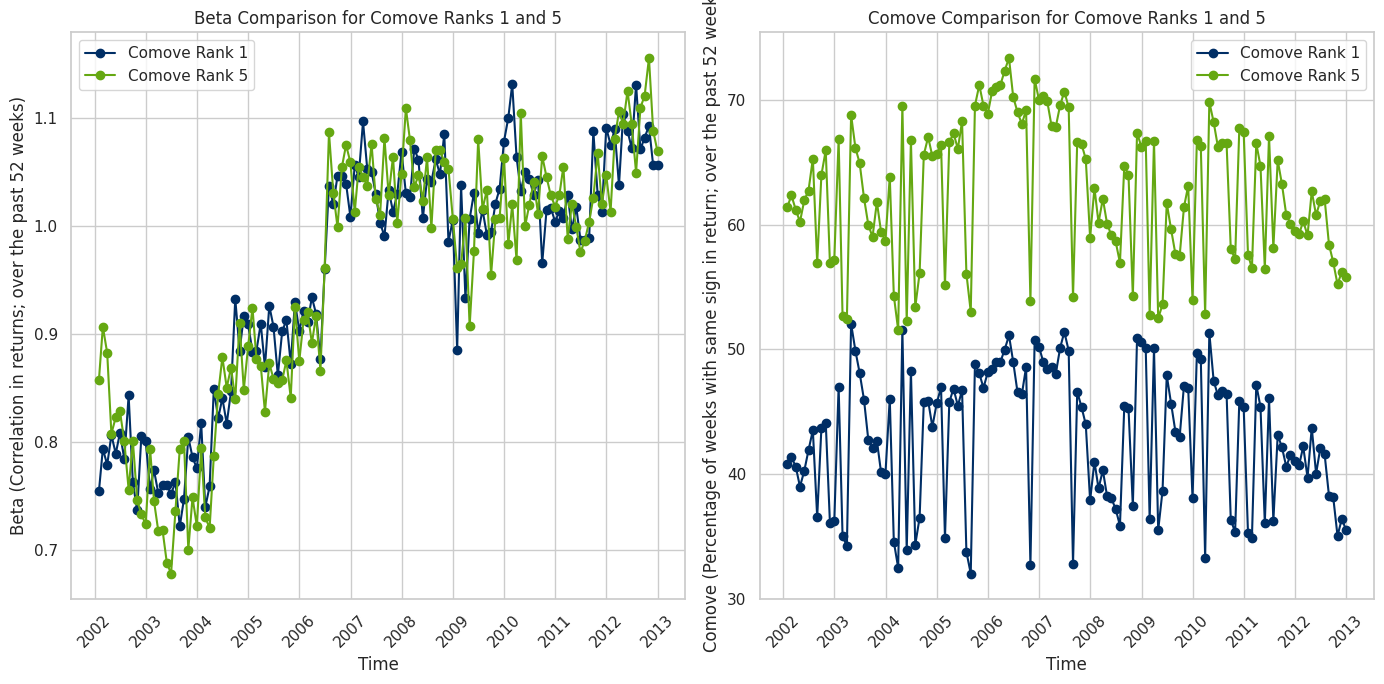

In [ ]:
# Set the aesthetic style of the plots
sns.set(style='whitegrid')

# Create additional plots for Comove ranks 1 and 5 on the same graph
plt.figure(figsize=(14, 7))
colors = {1: '#002E65', 5: '#65A812'}  # Map comove ranks to specific colors

# Beta comparison plot
plt.subplot(1, 2, 1)
for rank in [1, 5]:
    data = comove_stats[rank]
    plt.plot(data['Months'], data['Beta'], marker='o', linestyle='-', label=f'Comove Rank {rank}', color=colors[rank])
plt.title('Beta Comparison for Comove Ranks 1 and 5')
plt.xlabel('Time')
plt.ylabel('Beta (Correlation in returns; over the past 52 weeks)')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set locator to each January
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only year
plt.xticks(rotation=45)

# Comove comparison plot
plt.subplot(1, 2, 2)
for rank in [1, 5]:
    data = comove_stats[rank]
    plt.plot(data['Months'], data['Comove'], marker='o', linestyle='-', label=f'Comove Rank {rank}', color=colors[rank])
plt.title('Comove Comparison for Comove Ranks 1 and 5')
plt.xlabel('Time')
plt.ylabel('Comove (Percentage of weeks with same sign in return; over the past 52 weeks)')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set locator to each January
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only year
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("ComoveBeta_Ranks1and5.png")
plt.show()

Despite fluctuations, the beta values for both ranks generally appear to stay within a certain range, suggesting that while the market risk (measured as beta) varies over time, it doesn’t exhibit extremely high volatility within these comove ranks. The right plot shows the comovement values for the same ranks. While same trends are followed (in market risk, perhaps), we can see that comovement in rank 5 is generally higher as in rank 1.

###### Statistics

Let's look at some of the most important statistics. For each month and rank, we have an average beta and comove of the stocks in that portfolio. We will look at the average of those average beta and comove per portfolio across the months.

In [ ]:
# Calculate average beta and comove for the highest and lowest comove ranks across all months
avg_high_rank_beta = np.mean(comove_stats[5]['Beta'])  # Assuming rank 5 is the highest
avg_low_rank_beta = np.mean(comove_stats[1]['Beta'])  # Assuming rank 1 is the lowest

avg_high_rank_comove = np.mean(comove_stats[5]['Comove'])
avg_low_rank_comove = np.mean(comove_stats[1]['Comove'])

# Calculate the differences and percentage variations
beta_difference = avg_high_rank_beta - avg_low_rank_beta
beta_variation_pct = (beta_difference / avg_diff_std_beta) * 100

comove_difference = avg_high_rank_comove - avg_low_rank_comove
comove_variation_pct = (comove_difference / avg_diff_std_comove) * 100

# Generate the summary text
summary_text = f"""This can also be illustrated by looking at the exposure of our portfolio sort to β and Comove. \
Our dependent double sort by first β and then Comove results in negligible exposure to β, but a strong variation in Comove between the long and the short leg of our strategy. \
The high Comove quintile exhibits an average β of {avg_high_rank_beta:.4f}, whereas the low Comove quintile exhibits an average β of {avg_low_rank_beta:.4f}, so that β varies by {beta_difference:.4f} or {beta_variation_pct:.2f}% of β’s standard deviation ({avg_diff_std_beta:.4f}). \
In contrast, the high Comove quintile exhibits an average Comove of {avg_high_rank_comove:.4f}, whereas the low Comove quintile exhibits an average Comove of {avg_low_rank_comove:.4f}, so that Comove varies by {comove_difference:.2f} or {comove_variation_pct:.2f}% of Comove’s standard deviation ({avg_diff_std_comove:.4f}). \
Hence, real historical stock returns do exhibit significant variation in Comove beyond dependence captured by β."""

print(summary_text)

This can also be illustrated by looking at the exposure of our portfolio sort to β and Comove. Our dependent double sort by first β and then Comove results in negligible exposure to β, but a strong variation in Comove between the long and the short leg of our strategy. The high Comove quintile exhibits an average β of 0.9504, whereas the low Comove quintile exhibits an average β of 0.9540, so that β varies by -0.0036 or -30.62% of β’s standard deviation (0.0117). In contrast, the high Comove quintile exhibits an average Comove of 62.6389, whereas the low Comove quintile exhibits an average Comove of 42.9479, so that Comove varies by 19.69 or -3571.94% of Comove’s standard deviation (-0.5513). Hence, real historical stock returns do exhibit significant variation in Comove beyond dependence captured by β.


### Calculating Averages per Portfolio per Month

Let's now calculate average statistics of each portfolio. We take the stocks in Stocks_Monthly_Dataframes['MMYYYY'] and calculate the averages of comove, beta and return of stocks with the same Comove rank in that year. We store the results in *Portfolios_Monthly_Dataframes['MMYYYY']*, where the average comove, beta, and return of each portfolio is given for that MMYYYY.

In [ ]:
# At this point, each DataFrame in Monthly_Dataframes has been updated with 'Beta rank' and 'Comove rank' columns.
Stocks_Monthly_Dataframes['012002'].head(2)  # For the year 2023 data

,Comove,Beta,Return,Beta rank,Comove rank
Name,,,,,
3I GROUP - TOT RETURN IND,47.169811,1.405906,-10.499001,5,1
ABB LTD N - TOT RETURN IND,60.377358,1.675130,-7.529581,5,5


In [ ]:
Portfolios_Monthly_Dataframes = {}

for key, df in Stocks_Monthly_Dataframes.items():


    if 'Comove rank' in df.columns:
        # Group by 'Comove Rank' and calculate the mean of 'Comove', 'Beta', and 'Yearly Return' for each group.
        grouped = df.groupby('Comove rank')[['Comove', 'Beta', 'Return']].mean()


        # Rename the columns by prefixing with "Avg.".
        # Method 1: Using rename() with a dictionary comprehension for dynamic column renaming.
        grouped = grouped.rename(columns={col: f'Avg. {col}' for col in grouped.columns})

        # Add the grouped and averaged dataframe to the new dictionary.
        Portfolios_Monthly_Dataframes[key] = grouped

In [ ]:
# Now, Portfolios_Yearly_Dataframes contains the required dataframes for each year,
# with the comove rank as the index and the average values of 'Comove', 'Beta', and 'Yearly Return' as columns.
Portfolios_Monthly_Dataframes['012002']

,Avg. Comove,Avg. Beta,Avg. Return
Comove rank,,,
1,40.776435,0.754675,1.038957
2,47.036102,0.852650,-1.133048
3,50.648072,0.813622,0.657551
4,53.959039,0.819501,-0.573638
5,61.450240,0.857848,-1.517494


### Calculating Differences in those Averages between High-Low Portfolio's per Month

Let's now, for each year, calculate the difference in statistics between the lowest and highest comove portfolio. We store the results in one big dataframe called *Monthly*.

In [ ]:
# Initialize an empty list to hold the data for the new dataframe.
data_for_monthly_df = []

# Extract the year suffix from each key and the corresponding differences.
for key, df in Portfolios_Monthly_Dataframes.items():

    # Calculate the difference between the highest and lowest Comove Ranks for each variable.
    # Ensure that both Comove Rank 5 and 1 exist in the dataframe to avoid KeyErrors.
    if 5 in df.index and 1 in df.index:
        diff = df.loc[5] - df.loc[1]
    else:
        # In case one of the ranks is missing, fill with NaN or some default value.
        diff = pd.Series([pd.NA, pd.NA, pd.NA], index=df.columns)

    # Append a dictionary with the year and the calculated differences to the list.
    data_for_monthly_df.append(diff.rename(key))

# Create the 'Yearly' dataframe from the list of dictionaries.
Monthly = pd.DataFrame(data_for_monthly_df)

# If the columns are not already named correctly (with 'Avg.' prefix from the previous step), rename them.
# This step might not be necessary if columns are already correctly named.
Monthly.columns = [f'Diff. {col}' for col in Monthly.columns]

In [ ]:
# Display or return the 'Yearly' dataframe.
Monthly.head(2)

,Diff. Avg. Comove,Diff. Avg. Beta,Diff. Avg. Return
012002,20.673805,0.103173,-2.556451
022002,20.975327,0.112973,-5.336219


### Writing the Data for the Statistical Tests Away

#### Variables that differ across portfolios and months
MMYYYY, Avg. Comove, Avg. Beta, Avg. Return, Comove rank and HighestComove_Dummy

We will now make one big dataframe *final_df* where we have the column of the MMYYYY, the column of the comove rank, Dummy variable 'HighestComove_Dummy', and the average of the monthly return, comove and beta of this particular portfolio.

In [ ]:
# Initialize an empty list to store the filtered and transformed dataframes
transformed_dfs = []

# Iterate through the dictionary
for name_df, df in Portfolios_Monthly_Dataframes.items():

    # Reset the index to filter on Comove rank, keeping the index as a column
    df_reset = df.reset_index()
    filtered_df = df_reset

    # Add a HighestComove_Dummy column: 0 if Comove rank is 1, 1 if Comove rank is 5
    filtered_df['HighestComove_Dummy'] = filtered_df['Comove rank'].apply(lambda x: 0 if x == 1 else 1)

    # Add a MMYYYY column: name of the dataframe
    filtered_df['MMYYYY'] = name_df

    # Select the necessary columns
    filtered_df = filtered_df[['MMYYYY', 'Avg. Comove', 'Comove rank', 'HighestComove_Dummy', 'Avg. Beta', 'Avg. Return']]

    # Append the transformed dataframe to the list
    transformed_dfs.append(filtered_df)

# Concatenate all transformed dataframes into one
final_df = pd.concat(transformed_dfs, ignore_index=True)

In [ ]:
# Display the final dataframe
final_df

,MMYYYY,Avg. Comove,Comove rank,HighestComove_Dummy,Avg. Beta,Avg. Return
0,012002,40.776435,1,0,0.754675,1.038957
1,012002,47.036102,2,1,0.852650,-1.133048
2,012002,50.648072,3,1,0.813622,0.657551
3,012002,53.959039,4,1,0.819501,-0.573638
4,012002,61.450240,5,1,0.857848,-1.517494
...,...,...,...,...,...,...
655,122012,35.547170,1,0,1.057214,1.762303
656,122012,41.560428,2,1,1.078385,2.244155
657,122012,45.484661,3,1,1.178723,2.716321
658,122012,48.812020,4,1,1.122452,3.057942


We have used Comovement and Beta to sort and form our portfolio's, but we will not use it in our regressions. As explained in the other notebook, the avg. return of stocks in a particular portfolio of a particular month is used a y variable. Our return column is still in %, so lets divide it by 100.

In [ ]:
final_df['Avg. Return'] = final_df['Avg. Return'] / 100

#### Variables that differ over months, but not portfolios
Monthly Market Return, Month, Year & Factors

Let's now add the statistics to the dataframe that are the same for all portfolios of a certain year.

In [ ]:
#Adding Monthly Market Return

# Convert the 'MMYYYY' column in final_df to string so its the same datatype
final_df['MMYYYY'] = final_df['MMYYYY'].astype(str)

# Reset the index of Index_YearlyReturn_Dataframe to use it for merging
Index_MonthlyReturn_Dataframe_reset = Index_MonthlyReturn_Dataframe.reset_index()

# Merge final_df with Index_YearlyReturn_Dataframe on the Year column
final_df = final_df.merge(Index_MonthlyReturn_Dataframe_reset, on='MMYYYY', how='left')

#Divide the monthly market return column by 100 so it is not in percentage anymore
final_df['Monthly Market Return'] = final_df['Monthly Market Return'] / 100

In [ ]:
# Adding Factors

final_df['MMYYYY'] = final_df['MMYYYY'].astype(int)

# Merge final_df with Index_YearlyReturn_Dataframe on the Year column
final_df = final_df.merge(Factors_Monthly_Dataframe, on='MMYYYY', how='left')

#All factors and rates of this dataframe are already in the correct format

In [ ]:
# Display the final dataframe
final_df

,MMYYYY,Avg. Comove,Comove rank,HighestComove_Dummy,Avg. Beta,Avg. Return,index,Monthly Market Return,Year_x,Month_x,...,HML,HML_Devil,RMW,CMA,UMD,UMD_Trend,BAB,QMJ,Carry,Seasonal
0,12002,40.776435,1,0,0.754675,0.010390,0,-0.000203,2002,1,...,0.0183,0.002349,0.0313,0.0258,0.057496,0.023426,0.000910,0.024064,0.018840,0.002665
1,12002,47.036102,2,1,0.852650,-0.011330,0,-0.000203,2002,1,...,0.0183,0.002349,0.0313,0.0258,0.057496,0.023426,0.000910,0.024064,0.018840,0.002665
2,12002,50.648072,3,1,0.813622,0.006576,0,-0.000203,2002,1,...,0.0183,0.002349,0.0313,0.0258,0.057496,0.023426,0.000910,0.024064,0.018840,0.002665
3,12002,53.959039,4,1,0.819501,-0.005736,0,-0.000203,2002,1,...,0.0183,0.002349,0.0313,0.0258,0.057496,0.023426,0.000910,0.024064,0.018840,0.002665
4,12002,61.450240,5,1,0.857848,-0.015175,0,-0.000203,2002,1,...,0.0183,0.002349,0.0313,0.0258,0.057496,0.023426,0.000910,0.024064,0.018840,0.002665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,122012,35.547170,1,0,1.057214,0.017623,131,0.000150,2012,12,...,0.0303,0.034407,-0.0073,0.0083,-0.004815,0.018981,-0.008512,-0.014081,-0.018884,-0.015747
656,122012,41.560428,2,1,1.078385,0.022442,131,0.000150,2012,12,...,0.0303,0.034407,-0.0073,0.0083,-0.004815,0.018981,-0.008512,-0.014081,-0.018884,-0.015747
657,122012,45.484661,3,1,1.178723,0.027163,131,0.000150,2012,12,...,0.0303,0.034407,-0.0073,0.0083,-0.004815,0.018981,-0.008512,-0.014081,-0.018884,-0.015747
658,122012,48.812020,4,1,1.122452,0.030579,131,0.000150,2012,12,...,0.0303,0.034407,-0.0073,0.0083,-0.004815,0.018981,-0.008512,-0.014081,-0.018884,-0.015747


#### Writing to Excel

Now, we will try to write this into an Excel file.

In [ ]:
# Write the DataFrame to an Excel file
final_df.to_excel('Monthly Data.xlsx', sheet_name='Portfolios', index=True)